### Nome: Fabio Grassiotto
### RA: 890441
### Disciplina: IA369Y, 2º S 2017

### T3 - Análise e Síntese de Emoções em Conteúdo Multimídia
### Atividade 6 - Tutorial: Emotion Recognition using Facial Landmarks, Python, DLib and OpenCV


#### 1. Instalação da biblioteca DLib, utilizada para extração de marcos faciais.

- Seguindo o tutorial, realizei o download e instalação da CMake e Boost-Python (biblioteca C++).
- No Windows 10 não foi possível compilar a biblioteca Boost mesmo após instalar o Visual Studio 2015 para ter acesso a um compilador C/C++ e aos headers da SDK do Windows.
- Uma vez instalado o compilador, foi possível compilar a biblioteca, mas ocorreram problemas de link com a DLib.
- Encontrei no site da Boost binários pré-compilados. Com os mesmos, ainda não foi possível instalar a DLib.
- Procurando pela internet, existe um pacote pronto para o ambiente Anaconda em Windows, o que foi utilizado para finalment instalar a DLib.

<cconda install -c conda-forge dlib=19.4

Fetching package metadata .............
Solving package specifications: .

The following NEW packages will be INSTALLED:

    boost:     1.64.0-py36_vc14_4 conda-forge [vc14]
    boost-cpp: 1.64.0-vc14_1      conda-forge [vc14]
    dlib:      19.4-np113py36_201 conda-forge
    mkl:       2017.0.3-0
    numpy:     1.13.1-py36_0
    vc:        14-0               conda-forge

Proceed ([y]/n)? y

mkl-2017.0.3-0 100% |###############################| Time: 0:01:00   2.20 MB/s
vc-14-0.tar.bz 100% |###############################| Time: 0:00:00 166.89 kB/s
boost-cpp-1.64 100% |###############################| Time: 0:00:14   2.01 MB/s
numpy-1.13.1-p 100% |###############################| Time: 0:00:01   2.40 MB/s
boost-1.64.0-p 100% |###############################| Time: 0:00:01 577.44 kB/s
dlib-19.4-np11 100% |###############################| Time: 0:00:02 973.30 kB/s</code>


In [15]:
import dlib
print(dlib.__version__)

19.4.0


Após executar o import, a dlib agora está disponível no Python.

#### 2. Teste do detector de landmarks

Ao executar o código do tutorial, o interpretador do Python acusa que a biblioteca cv2 (Open CV 3) não está disponível.
Para Python 3.6, é necessário fazer o download do binário no site https://www.lfd.uci.edu/~gohlke/pythonlibs/#opencv e instalar manualmente:

pip install opencv_python-3.3.1-cp36-cp36m-win_amd64.whl
Processing d:\development\libs\opencv_python-3.3.1-cp36-cp36m-win_amd64.whl
Installing collected packages: opencv-python
Successfully installed opencv-python-3.3.1

In [ ]:
import cv2
print(cv2.__version__)

O código abaixo foi então executado para capturar e detectar o rosto usando a webcam do computador:

In [ ]:
#Import required modules
import cv2
import dlib

#Set up some required objects
video_capture = cv2.VideoCapture(0) #Webcam object
detector = dlib.get_frontal_face_detector() #Face detector
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Landmark identifier. Set the filename to whatever you named the downloaded file

while True:
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray)

    detections = detector(clahe_image, 1) #Detect the faces in the image

    for k,d in enumerate(detections): #For each detected face
        
        shape = predictor(clahe_image, d) #Get coordinates
        for i in range(1,68): #There are 68 landmark points on each face
            cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2) #For each point, draw a red circle with thickness2 on the original frame

    cv2.imshow("image", frame) #Display the frame

    if cv2.waitKey(1) & 0xFF == ord('q'): #Exit program when the user presses 'q'
        break

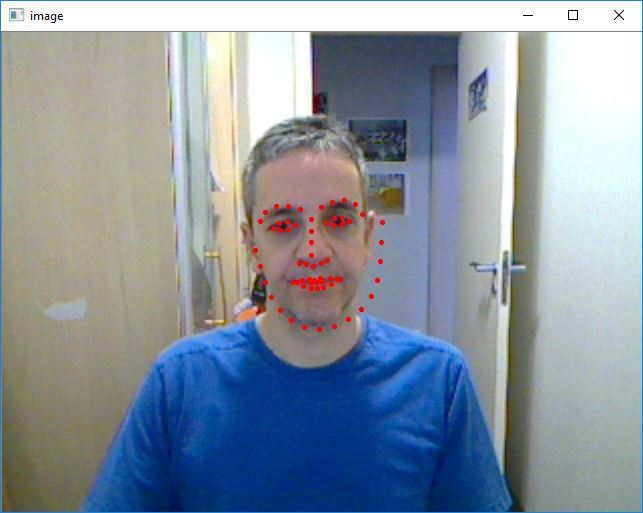

In [24]:
from IPython.display import Image, display
display(Image(filename='face_detect.jpg', embed=True))

#### 3. Extração de features de rostos

O código acima foi então modificado para a extração das coordenadas dos marcos faciais (feature) através da função get_landmarks().

In [23]:
import cv2
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        for x, y in zip(xlist, ylist): #Store all landmarks in one list in the format x1,y1,x2,y2,etc.
            landmarks.append(x)
            landmarks.append(y)
    if len(detections) > 0:
        return landmarks
    else: #If no faces are detected, return error message to other function to handle
        landmarks = "error"
        return landmarks

A extração dos marcos faciais como feature pode no entanto ser um problema devido à movimentação do rosto. No tutorial, o autor inicialmente propõe normalizar as coordenadas dos marcos:

<code>xnorm = [(i-min(xlist))/(max(xlist)-min(xlist)) for i in xlist]
ynorm = [(i-min(ylist))/(max(ylist)-min(ylist)) for i in ylist]</code>

Essa abordagem provoca perda de informação quando comparamos duas fotos muito similares.
Uma alternativa seria calcular a posição dos pontos em relação a um centro de gravidade facial conforme ilustrado abaixo no tutorial.

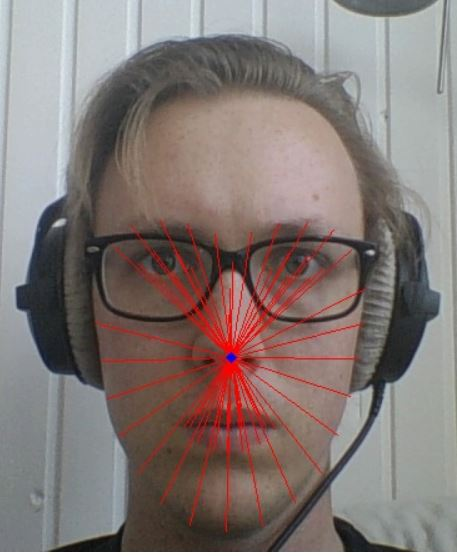

In [25]:
from IPython.display import Image, display
display(Image(filename='centerofgravity.jpg', embed=True))

O tutorial decorre então sobre a razão de não se usar a ponta do nariz como centro dos pontos. A variância de tipos de nariz e posição da cabeça pode confundir o classificador.

Implementando a idéia do centro gravidade em Python:

In [26]:
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        xmean = np.mean(xlist) #Find both coordinates of centre of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] #Calculate distance centre <-> other points in both axes
        ycentral = [(y-ymean) for y in ylist]
        
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1: 
        data['landmarks_vestorised'] = "error"